This notebook best viewed here: https://nbviewer.jupyter.org

# need to rewrite for Jack pine

This notebook is for the coastal variety of Douglas fir GEA mapping pops
* First I randomly choose one SNP per contig (only for contigs ≥ 1Kbp) with 20≤depth<1000. I tried filtering for less missing data, but this skewed MAF spectra from original dataset, so I used current data at <25% missing data. 
* I then LD-prune these random SNPs to use for structure correction in baypass. I used an LD threshold of r2<~0.33 (the 99.9th percentile) this allowed for sufficient loci at the end of LD pruning. Across each filtering step and after LD pruning I compare filtered/chosen loci to the original MAF spectrum to ensure representativeness.
* I use LD-pruned SNPs to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.987). I took the average of these matrices for use downstream, this average matrix was highly correlated to each of the other matrices (r2 > 0.995).
* Then I create the commands and remaining files to run baypass in IS mode (eg efile) and gfile for SNPs in our data with ADP < 1000 (average depth across pools). To parallelize baypass calls, I split up the total SNPs into 824 small gfiles of about 1500 loci.


In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled'
snpdir = op.join(DIR, 'snpsANDindels/03_maf-p05_RD-recalculated')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# Choose SNPs for GEA structure correction in baypass

For SNPs with MAF > 0.05 and for all pops: 20 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.5th percentile of r2

#### get the snps

In [2]:
lview,dview = get_client()

56 56


In [3]:
def get_mafdict(afs, roundto):
    # bins for maf spectrum
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df
dview['get_skipto_df'] = get_skipto_df

def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['unstitched_chrom', 'unstitched_locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['unstitched_locus'].tolist()
    return chunk

In [4]:
snpdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated'

In [3]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt 1235752


In [6]:
# filter for depth in parallel as I read it in
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)


Watching 124 jobs ...


100%|██████████| 124/124 [00:26<00:00,  4.61it/s]


In [7]:
# combine depth-filtered chunks into one df
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

(649641, 84)


,unstitched_chrom,unstitched_locus,AF,MAF,JP_p98.DP,JP_p31.DP,JP_p93.DP,JP_p24.DP,JP_p14.DP,JP_p70.DP,JP_p8.DP,JP_p95.DP,JP_p57.DP,JP_p96.DP,JP_p51.DP,JP_p73.DP,JP_p83.DP,JP_p26.DP,JP_p68.DP,JP_p6.DP,JP_p92.DP,JP_p72.DP,JP_p94.DP,JP_p62.DP,JP_p99.DP,JP_p39.DP,JP_p97.DP,JP_p90.DP,JP_p37.DP,JP_p84.DP,JP_p27.DP,JP_p82.DP,JP_p29.DP,JP_p20.DP,JP_p77.DP,JP_p4.DP,JP_p101.DP,JP_p60.DP,JP_p102.DP,JP_p100.DP,JP_p42.DP,JP_p103.DP,JP_p48.DP,JP_p79.DP,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p24.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ
>super4-47333,>super4,>super4-47333,0.105707,0.105707,61.0,121.0,85.0,144.0,133.0,118.0,92.0,85.0,136.0,101.0,144.0,132.0,104.0,185.0,125.0,67.0,123.0,154.0,115.0,122.0,90.0,127.0,94.0,94.0,76.0,117.0,147.0,78.0,134.0,142.0,130.0,78.0,60.0,106.0,44.0,77.0,109.0,103.0,134.0,105.0,8.2%,9.09%,21.18%,0%,8.27%,13.56%,5.43%,4.71%,3.68%,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,7.46%,18.7%,3.25%,20%,2.46%,13.33%,3.94%,7.45%,14.89%,2.63%,5.98%,3.4%,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,5.5%,13.59%,0%,8.57%
>super4-47418,>super4,>super4-47418,0.217593,0.217593,70.0,140.0,97.0,155.0,137.0,126.0,99.0,109.0,145.0,94.0,156.0,138.0,97.0,190.0,120.0,75.0,127.0,157.0,94.0,121.0,91.0,137.0,99.0,100.0,79.0,141.0,132.0,85.0,133.0,143.0,125.0,70.0,68.0,110.0,44.0,89.0,112.0,102.0,121.0,122.0,20%,18.57%,25.77%,7.1%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%
>super4-47461,>super4,>super4-47461,0.090661,0.090661,77.0,133.0,103.0,161.0,120.0,115.0,97.0,109.0,141.0,96.0,156.0,132.0,83.0,178.0,119.0,76.0,121.0,147.0,85.0,116.0,84.0,143.0,86.0,98.0,79.0,141.0,136.0,83.0,134.0,132.0,116.0,59.0,67.0,99.0,46.0,84.0,102.0,91.0,123.0,125.0,0%,0%,4.85%,40.99%,7.5%,16.52%,6.19%,5.5%,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,6.98%,3.06%,15.19%,9.93%,11.76%,6.02%,11.19%,6.06%,10.34%,8.47%,0%,6.06%,0%,11.9%,1.96%,2.2%,19.51%,19.2%
>super4-47513,>super4,>super4-47513,0.520739,0.479261,77.0,133.0,97.0,168.0,96.0,115.0,103.0,99.0,136.0,106.0,157.0,135.0,100.0,175.0,124.0,71.0,129.0,150.0,104.0,120.0,81.0,138.0,88.0,98.0,84.0,153.0,139.0,83.0,119.0,148.0,130.0,65.0,67.0,100.0,46.0,83.0,116.0,90.0,139.0,120.0,55.84%,56.39%,39.18%,11.9%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%
>super4-47541,>super4,>super4-47541,0.051038,0.051038,80.0,132.0,96.0,155.0,100.0,121.0,107.0,108.0,128.0,114.0,161.0,143.0,101.0,173.0,128.0,66.0,129.0,147.0,96.0,120.0,78.0,139.0,82.0,99.0,86.0,146.0,128.0,87.0,122.0,134.0,131.0,67.0,66.0,95.0,46.0,83.0,120.0,96.0,137.0,117.0,0%,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,9.09%,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,5.75%,16.39%,6.72%,7.63%,2.99%,0%,5.26%,0%,1.2%,0%,0%,2.19%,12.82%


In [8]:
# how many chromosomes
luni(snps['unstitched_chrom'])

32519

#### reduce those snps on contigs > 1Kbp

In [9]:
# get contig lengths
lengths = pd.read_table('/data/database/Pita_db/Pita2_stitched_v3/pita2_stitch_v3.order', header=None)
lengths.head()

,0,1,2,3,4
0,Scaffold_1,>super4,1,1040066,1040066
1,Scaffold_2,>super27,1,1013948,1013948
2,Scaffold_3,>super81,1,1160147,1160147
3,Scaffold_4,>super124,1,1132644,1132644
4,Scaffold_5,>super131,1,1019530,1019530


In [10]:
# get a dict of contigs and there length if length > 1000
lens = dict((contig,length) for (contig,length) in zip(lengths[1],lengths[4]) if length>1000)
len(lens.keys())

1019201

In [11]:
snps.head()

,unstitched_chrom,unstitched_locus,AF,MAF,JP_p98.DP,JP_p31.DP,JP_p93.DP,JP_p24.DP,JP_p14.DP,JP_p70.DP,JP_p8.DP,JP_p95.DP,JP_p57.DP,JP_p96.DP,JP_p51.DP,JP_p73.DP,JP_p83.DP,JP_p26.DP,JP_p68.DP,JP_p6.DP,JP_p92.DP,JP_p72.DP,JP_p94.DP,JP_p62.DP,JP_p99.DP,JP_p39.DP,JP_p97.DP,JP_p90.DP,JP_p37.DP,JP_p84.DP,JP_p27.DP,JP_p82.DP,JP_p29.DP,JP_p20.DP,JP_p77.DP,JP_p4.DP,JP_p101.DP,JP_p60.DP,JP_p102.DP,JP_p100.DP,JP_p42.DP,JP_p103.DP,JP_p48.DP,JP_p79.DP,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p24.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ
>super4-47333,>super4,>super4-47333,0.105707,0.105707,61.0,121.0,85.0,144.0,133.0,118.0,92.0,85.0,136.0,101.0,144.0,132.0,104.0,185.0,125.0,67.0,123.0,154.0,115.0,122.0,90.0,127.0,94.0,94.0,76.0,117.0,147.0,78.0,134.0,142.0,130.0,78.0,60.0,106.0,44.0,77.0,109.0,103.0,134.0,105.0,8.2%,9.09%,21.18%,0%,8.27%,13.56%,5.43%,4.71%,3.68%,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,7.46%,18.7%,3.25%,20%,2.46%,13.33%,3.94%,7.45%,14.89%,2.63%,5.98%,3.4%,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,5.5%,13.59%,0%,8.57%
>super4-47418,>super4,>super4-47418,0.217593,0.217593,70.0,140.0,97.0,155.0,137.0,126.0,99.0,109.0,145.0,94.0,156.0,138.0,97.0,190.0,120.0,75.0,127.0,157.0,94.0,121.0,91.0,137.0,99.0,100.0,79.0,141.0,132.0,85.0,133.0,143.0,125.0,70.0,68.0,110.0,44.0,89.0,112.0,102.0,121.0,122.0,20%,18.57%,25.77%,7.1%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%
>super4-47461,>super4,>super4-47461,0.090661,0.090661,77.0,133.0,103.0,161.0,120.0,115.0,97.0,109.0,141.0,96.0,156.0,132.0,83.0,178.0,119.0,76.0,121.0,147.0,85.0,116.0,84.0,143.0,86.0,98.0,79.0,141.0,136.0,83.0,134.0,132.0,116.0,59.0,67.0,99.0,46.0,84.0,102.0,91.0,123.0,125.0,0%,0%,4.85%,40.99%,7.5%,16.52%,6.19%,5.5%,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,6.98%,3.06%,15.19%,9.93%,11.76%,6.02%,11.19%,6.06%,10.34%,8.47%,0%,6.06%,0%,11.9%,1.96%,2.2%,19.51%,19.2%
>super4-47513,>super4,>super4-47513,0.520739,0.479261,77.0,133.0,97.0,168.0,96.0,115.0,103.0,99.0,136.0,106.0,157.0,135.0,100.0,175.0,124.0,71.0,129.0,150.0,104.0,120.0,81.0,138.0,88.0,98.0,84.0,153.0,139.0,83.0,119.0,148.0,130.0,65.0,67.0,100.0,46.0,83.0,116.0,90.0,139.0,120.0,55.84%,56.39%,39.18%,11.9%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%
>super4-47541,>super4,>super4-47541,0.051038,0.051038,80.0,132.0,96.0,155.0,100.0,121.0,107.0,108.0,128.0,114.0,161.0,143.0,101.0,173.0,128.0,66.0,129.0,147.0,96.0,120.0,78.0,139.0,82.0,99.0,86.0,146.0,128.0,87.0,122.0,134.0,131.0,67.0,66.0,95.0,46.0,83.0,120.0,96.0,137.0,117.0,0%,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,9.09%,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,5.75%,16.39%,6.72%,7.63%,2.99%,0%,5.26%,0%,1.2%,0%,0%,2.19%,12.82%


In [12]:
# reduce reduced columns to only those that matter
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['unstitched_chrom'].isin(keys(lens))].copy()
reduced = reduced.loc[:, freqcols + ['unstitched_chrom', 'AF', 'MAF']]
reduced.shape, snps.shape

((641106, 43), (649641, 84))

In [13]:
# how many pops?
len(freqcols)

40

In [14]:
# min contig length
min(lens.values())

1001

46
46


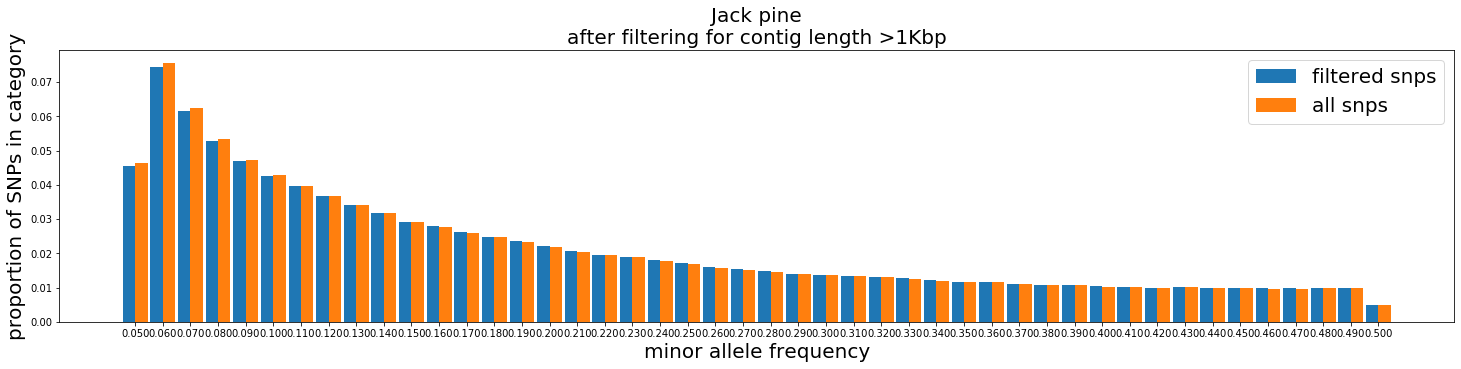

In [15]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for contig length >1Kbp')

#### reduce to no missing data 

In [16]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[~reduced[col].isnull()].index

In [17]:
# get loci from each pop without missing data
reduce_col_outs = []
for col in nb(freqcols):
    reduce_col_outs.append(reduce_col(col))

100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


In [18]:
# combine returns to get loci with no missing data across pop.FREQ cols
nomissingloci = snps.index.tolist()
for out in nb(reduce_col_outs):
    nomissingloci = list(set(nomissingloci).intersection(out))
len(nomissingloci), luni(nomissingloci)

100%|██████████| 40/40 [00:14<00:00,  2.70it/s]


(641106, 641106)

In [19]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p24.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF
>super4-47333,8.2%,9.09%,21.18%,0%,8.27%,13.56%,5.43%,4.71%,3.68%,7.92%,6.25%,5.3%,8.65%,8.65%,18.4%,7.46%,18.7%,3.25%,20%,2.46%,13.33%,3.94%,7.45%,14.89%,2.63%,5.98%,3.4%,2.56%,6.72%,6.34%,25.38%,0%,28.33%,19.81%,18.18%,9.09%,5.5%,13.59%,0%,8.57%,>super4,0.105707,0.105707
>super4-47418,20%,18.57%,25.77%,7.1%,21.17%,27.78%,34.34%,10.09%,23.45%,25.53%,37.82%,39.13%,19.59%,18.95%,15%,22.67%,13.39%,33.12%,10.64%,39.67%,14.29%,29.93%,4.04%,11%,27.85%,18.44%,27.27%,15.29%,49.62%,30.77%,32%,15.71%,5.88%,20%,15.91%,17.98%,19.64%,21.57%,9.92%,17.21%,>super4,0.217593,0.217593
>super4-47461,0%,0%,4.85%,40.99%,7.5%,16.52%,6.19%,5.5%,7.09%,2.08%,8.97%,15.15%,9.64%,5.06%,10.92%,13.16%,1.65%,19.05%,1.18%,1.72%,3.57%,16.78%,6.98%,3.06%,15.19%,9.93%,11.76%,6.02%,11.19%,6.06%,10.34%,8.47%,0%,6.06%,0%,11.9%,1.96%,2.2%,19.51%,19.2%,>super4,0.090661,0.090661
>super4-47513,55.84%,56.39%,39.18%,11.9%,50%,34.78%,52.43%,70.71%,56.62%,63.21%,48.41%,34.07%,45%,68%,41.94%,56.34%,65.12%,36%,55.77%,50%,58.02%,47.1%,63.64%,73.47%,47.62%,53.59%,57.55%,60.24%,32.77%,47.3%,28.46%,64.62%,64.18%,54%,63.04%,46.99%,49.14%,55.56%,69.78%,49.17%,>super4,0.520739,0.479261
>super4-47541,0%,0%,0%,0%,11%,16.53%,2.8%,0.93%,7.03%,0%,6.83%,10.49%,8.91%,2.31%,9.38%,9.09%,0%,11.56%,0%,1.67%,5.13%,16.55%,0%,4.04%,3.49%,11.64%,7.81%,5.75%,16.39%,6.72%,7.63%,2.99%,0%,5.26%,0%,1.2%,0%,0%,2.19%,12.82%,>super4,0.051038,0.051038


46
46


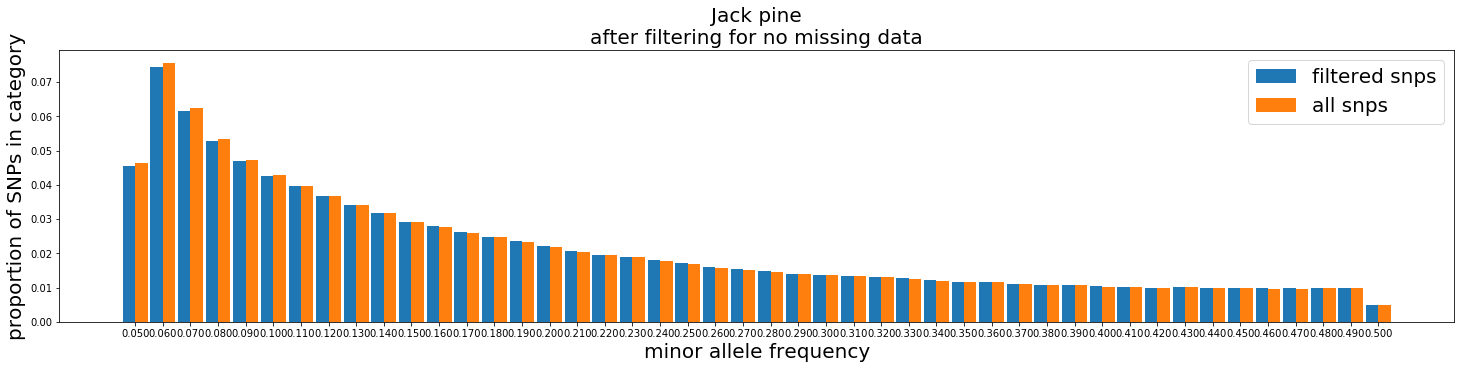

In [20]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter filtering for no missing data')

#### try to reduce to X% missing data ... 

I had to do this for Doug-fir, but I don't have to for Jack pine; just leaving the code here

In [ ]:
# def filter_perc(df, perc=0.10):
#     """Filter df for missing data below perc."""
#     import pandas
#     from tqdm.notebook import tqdm as tnb
    
#     freqcols = [col for col in df.columns if '.FREQ' in col]
#     keep = []
#     for locus in tnb(df.index):
#         if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
#             keep.append(locus)
#     return keep

In [ ]:
# # see how filtering affects congruence between pre- and post-filtered data (figs below)
# jobs = []
# tosend = []
# i = 0
# for locus in tnb(reduced.index):
#     tosend.append(locus)
#     if len(tosend) == 21732 or (i+1)==nrow(reduced):
# #         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))  # see fig below
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))  # see fig below
#         tosend = []
#     i += 1
# watch_async(jobs)

In [ ]:
# # gather parallel jobs
# perc_loci = []
# for j in jobs:
#     perc_loci.extend(j.r)
# len(perc_loci)

In [ ]:
# # compare MAF spectrum between no-missing and precursor
# make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
#                  get_mafdict(snps['AF'], roundto=2),
#                  title='Jack pine\nafter filtering for <10% missing data')

In [ ]:
# # compare MAF spectrum between no-missing and precursor
# make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
#                  get_mafdict(snps['AF'], roundto=2),
#                  title='Jack pine\nafter filtering for <20% missing data')

#### choose one snp per contig at random

In [21]:
def choose_random_loci(df):
    """For each chrom in df['unstitched_chrom'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['unstitched_chrom']):
        loci = df.loc[chrom, 'unstitched_locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [22]:
# how many chroms do I send to a job? A: math.ceil(476.42)
luni(reduced['unstitched_chrom']), luni(reduced['unstitched_chrom'])/len(lview)

(30611, 546.625)

In [23]:
# change the index for easy sending
reduced['unstitched_locus'] = reduced.index.tolist()
reduced.index = reduced['unstitched_chrom'].tolist()

In [24]:
nrow(reduced), luni(reduced['unstitched_locus'])

(641106, 641106)

In [25]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['unstitched_chrom'])
for chrom in nb(uni(reduced['unstitched_chrom']), desc='sending jobs'):
    tosend.append(chrom)
    if len(tosend) == 462 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

sending jobs: 100%|██████████| 30611/30611 [00:10<00:00, 2882.81it/s]



Watching 67 jobs ...


100%|██████████| 67/67 [00:00<00:00, 167772.16it/s]


In [26]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['unstitched_chrom'])

True

In [27]:
# reset index, reduce reduced to only randomloci
red = reduced[reduced['unstitched_locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

30611 30611


,JP_p98.FREQ,JP_p31.FREQ,JP_p93.FREQ,JP_p24.FREQ,JP_p14.FREQ,JP_p70.FREQ,JP_p8.FREQ,JP_p95.FREQ,JP_p57.FREQ,JP_p96.FREQ,JP_p51.FREQ,JP_p73.FREQ,JP_p83.FREQ,JP_p26.FREQ,JP_p68.FREQ,JP_p6.FREQ,JP_p92.FREQ,JP_p72.FREQ,JP_p94.FREQ,JP_p62.FREQ,JP_p99.FREQ,JP_p39.FREQ,JP_p97.FREQ,JP_p90.FREQ,JP_p37.FREQ,JP_p84.FREQ,JP_p27.FREQ,JP_p82.FREQ,JP_p29.FREQ,JP_p20.FREQ,JP_p77.FREQ,JP_p4.FREQ,JP_p101.FREQ,JP_p60.FREQ,JP_p102.FREQ,JP_p100.FREQ,JP_p42.FREQ,JP_p103.FREQ,JP_p48.FREQ,JP_p79.FREQ,unstitched_chrom,AF,MAF,unstitched_locus
>super4,95.65%,95.16%,90.7%,51.01%,86.24%,79.26%,84.03%,92.31%,91.38%,96.69%,89.77%,85.23%,84.62%,90.5%,89.23%,91.43%,95.45%,77.52%,93.07%,94.96%,84.62%,82.31%,94.52%,97.67%,82.76%,88%,86.4%,86.52%,82.68%,82.58%,91.11%,65.28%,95.08%,90.53%,97.96%,86.49%,94.89%,93.07%,80%,78.45%,>super4,0.874979,0.125021,>super4-47629
>super27,20.63%,10%,4.62%,0%,6.45%,5.63%,0%,10.26%,0%,29.41%,0%,0%,0%,0%,0%,4.48%,19.75%,8%,8.96%,4.84%,32.73%,0%,18%,4.55%,0%,10.17%,0%,3.85%,6.52%,0%,7.84%,4.35%,52.94%,3.23%,17.39%,17.78%,0%,1.89%,3.7%,10.17%,>super27,0.078727,0.078727,>super27-265948
>super81,40.74%,12.5%,41.67%,0%,7.14%,36.62%,4.76%,42.86%,17.31%,24.07%,30%,3.33%,35.19%,5.26%,7.58%,10%,20.83%,4.62%,46.03%,33.87%,41.3%,2.22%,31.82%,35.9%,15.79%,32.39%,2.27%,17.86%,0%,6.12%,20.83%,29.03%,37.5%,27.14%,31.43%,40%,21.31%,51.35%,2.94%,33.9%,>super81,0.234060,0.234060,>super81-800477
>super124,13.79%,6.06%,29.23%,48.15%,5.48%,13.48%,20.69%,16%,19.79%,17.07%,2.82%,22.73%,9.09%,36.26%,9.72%,36.23%,11.76%,20.73%,13.48%,5.56%,14.67%,20.69%,20.31%,25.58%,5.88%,16.88%,27.91%,59.09%,7.02%,17.86%,10.96%,21.74%,19.44%,6.31%,27.27%,46.48%,14.29%,8.93%,20.27%,6.02%,>super124,0.199180,0.199180,>super124-1063998
>super131,20.69%,14.29%,6.33%,0%,25%,14.71%,5.88%,15.85%,13.92%,24.36%,24.32%,37.5%,9.52%,17.86%,11.76%,5.97%,23.53%,20.62%,13.58%,15.96%,35.48%,20.93%,9.59%,0%,21.95%,17.11%,8.93%,17.86%,5.56%,25.68%,9.62%,29.17%,24.24%,7.69%,12.12%,23.08%,16.07%,9.52%,25%,7.94%,>super131,0.172895,0.172895,>super131-86964


In [28]:
# reset index
reduced = red.copy()
reduced.index = reduced['unstitched_locus'].tolist()
reduced.shape

(30611, 44)

46
46


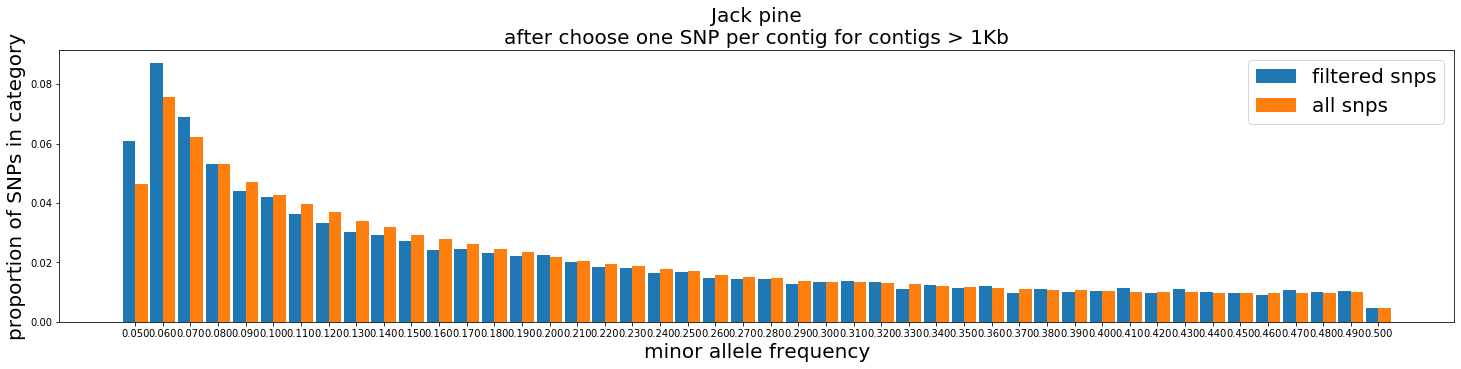

In [29]:
# compare distributions
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [35]:
lview,dview = get_client()

25 25


In [36]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci, **kwargs):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [37]:
len(randomloci)

30611

In [38]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)


Watching 128 jobs ...


100%|██████████| 128/128 [03:28<00:00,  1.63s/it]


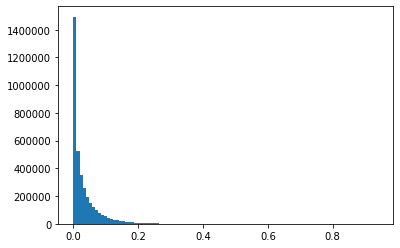

In [39]:
r2vals = []
for j in jobs:
    if j.ready():
        r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [40]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.4876124048091995

In [41]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]

0.33304280316708873

In [42]:
# get 99.5th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.995)]

0.24178651269978949

In [43]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.20473324092498427

In [44]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]

0.1681782616000474

In [45]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]

0.14720568352298302

In [46]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

3610936


0.9890607046256035

In [47]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)  # how many loci are below this perc?
        break
(i+1)/len(r2vals)

3644442


0.9982382305611669

In [48]:
# use 99.9th percentile
# I could not get loci from 99.5th percentile to converge on cov matrix ~ 2853 loci
# 99th percentile resulted in too few loci to estimate omega
r2thresh = 0.33304280316708873

#### LD prune random loci¶

In [49]:
# number of loci starting out
reduced.shape

(30611, 44)

In [50]:
len(randomloci)

30611

In [51]:
snps.shape, reduced.shape

((649641, 84), (30611, 44))

In [52]:
# num pops
len(freqcols)

40

In [53]:
# increase engines
lview,dview = get_client()

40 40


In [54]:
# attach data to engines

# dict with key=locus, val = list of freqs for that locus
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))

dview['freqs'] = freqs
# dview['reduced'] = None
len(freqs)

30611

In [55]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    """Prune loci by LD (r2thresh)."""
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [56]:
r2thresh

0.33304280316708873

In [57]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in nb(randomloci):
    tosend = randomloci[i+1:] # pairwise comparisons
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

100%|██████████| 30611/30611 [03:15<00:00, 156.20it/s]


In [58]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 30321, 30323, 10244)


10243

In [59]:
# save
baydir = makedir(op.join(snpdir, 'baypass'))
# pkl = op.join(baydir, 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p24439.pkl')  # 99.5th percentile
pkl = op.join(baydir, 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p33304.pkl')
pkldump(keep, pkl)

46
46


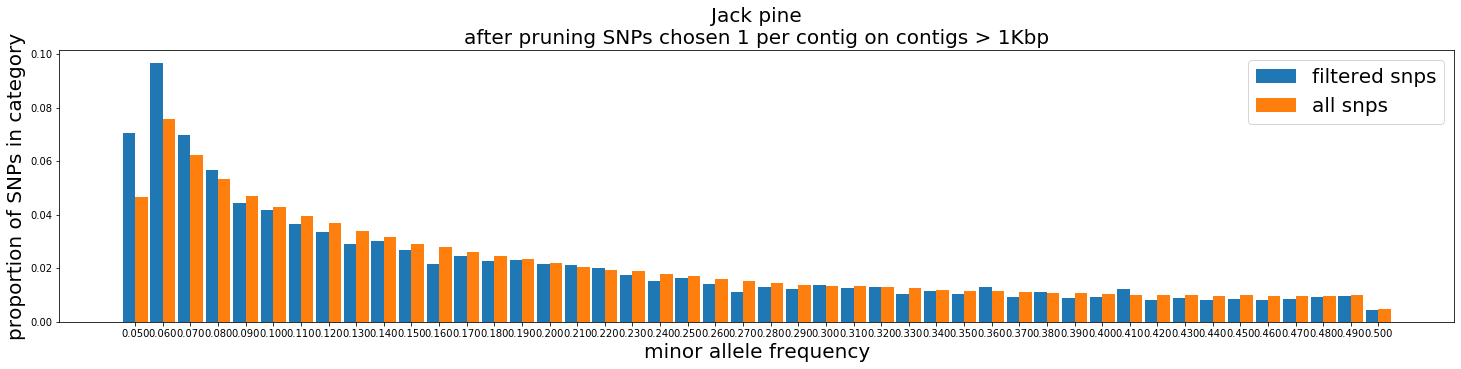

In [60]:
# compare distributions
keeping = reduced[reduced.index.isin(keep)].copy()
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Jack pine\nafter pruning SNPs chosen 1 per contig on contigs > 1Kbp')

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [ ]:
# RESTART NOTEBOOK! I used lower depth threshold for structure estimation

In [2]:
lview,dview = get_client()

56 56


In [3]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [4]:
# see what's in baydir - I'll be overwriting the txt files
fs(baydir, bnames=True, dirs=False)

['neutral_gfile_HEADERIDX.txt',
 'neutral_gfile_noheaderidx.txt',
 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p24439.pkl',
 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p33304.pkl',
 'poolsizefile_HEADERIDX.txt',
 'poolsizefile_noheaderidx.txt']

In [5]:
# load LD-pruned loci
prunedloci = pklload(op.join(baydir, 'nomissing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p33304.pkl'))
len(prunedloci)

10243

In [7]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)


Watching 124 jobs ...


100%|██████████| 124/124 [00:25<00:00,  4.91it/s]


In [8]:
# get pruned SNPs from read-in
snps = pd.concat([j.r for j in jobs])
snps.index = snps['unstitched_locus'].tolist()
reduced = snps[snps.index.isin(prunedloci)].copy()
reduced.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
>super124-1063998,Scaffold_4,1063998,G,T,0.199180,-10.0,SNP,PASS,65,5,35,0,0,G/T,25.0,58,58.0,13.79%,3.017200e-03,8.0,50.0,G/G,44.0,33,33.0,6.06%,2.461500e-01,2.0,31.0,G/T,63.0,65,65.0,29.23%,4.086100e-07,19.0,46.0,G/T,95.0,54,54.0,48.15%,2.717100e-10,26.0,28.0,G/G,95.0,73,73.0,5.48%,...,33.0,27.27%,1.042000e-03,9.0,24.0,G/T,120.0,71,71.0,46.48%,8.710600e-13,33.0,38.0,G/T,31.0,70,70.0,14.29%,6.915300e-04,10.0,60.0,G/T,15.0,56,56.0,8.93%,2.847300e-02,5.0,51.0,G/T,48.0,74,74.0,20.27%,1.387700e-05,15.0,59.0,G/T,15.0,83,83.0,6.02%,2.937300e-02,5.0,78.0,Scaffold_4-1063998,>super124,1063998,>super124-1063998,0.199180
>super144-41487,Scaffold_6,41487,C,T,0.169817,-10.0,SNP,PASS,59,9,31,0,0,C/T,38.0,64,64.0,18.75%,1.384200e-04,12.0,52.0,C/C,40.0,35,35.0,8.57%,1.195700e-01,3.0,32.0,C/T,28.0,64,64.0,14.06%,1.444700e-03,9.0,55.0,C/C,84.0,51,51.0,1.96%,5.000000e-01,1.0,50.0,C/T,58.0,85,85.0,21.18%,...,35.0,17.14%,1.238000e-02,6.0,29.0,C/T,42.0,58,58.0,22.41%,5.734900e-05,13.0,45.0,C/T,63.0,67,67.0,28.36%,4.312100e-07,19.0,48.0,C/T,38.0,59,59.0,20.34%,1.312100e-04,12.0,47.0,C/C,65.0,55,55.0,7.27%,5.907600e-02,4.0,51.0,C/T,46.0,58,58.0,24.14%,2.505500e-05,14.0,44.0,Scaffold_6-41487,>super144,41487,>super144-41487,0.169817
>super215-1038992,Scaffold_7,1038992,C,T,0.092353,-10.0,SNP,PASS,237,0,40,0,0,C/T,82.0,188,188.0,13.83%,5.890700e-09,26.0,162.0,C/T,39.0,225,225.0,5.78%,1.021300e-04,13.0,212.0,C/T,149.0,236,236.0,19.49%,1.249400e-15,46.0,190.0,C/T,122.0,312,312.0,12.5%,5.126200e-13,39.0,273.0,C/T,68.0,283,283.0,7.77%,...,114.0,10.53%,1.799600e-04,12.0,102.0,C/T,56.0,174,174.0,10.34%,2.400600e-06,18.0,156.0,C/T,52.0,264,264.0,6.44%,5.847900e-06,17.0,247.0,C/T,75.0,208,208.0,11.54%,2.949200e-08,24.0,184.0,C/T,97.0,261,261.0,11.88%,1.806900e-10,31.0,230.0,C/T,77.0,268,268.0,9.33%,1.657400e-08,25.0,243.0,Scaffold_7-1038992,>super215,1038992,>super215-1038992,0.092353
>super754-28218,Scaffold_15,28218,A,G,0.899053,-10.0,SNP,PASS,90,0,2,38,0,A/G,228.0,65,65.0,78.46%,1.308800e-23,51.0,14.0,G/G,255.0,91,91.0,93.41%,2.729400e-45,85.0,6.0,G/G,255.0,79,79.0,84.81%,1.362500e-32,67.0,12.0,G/G,255.0,124,124.0,94.35%,4.874800e-63,117.0,7.0,G/G,255.0,96,96.0,87.5%,...,29.0,79.31%,5.398400e-11,23.0,6.0,G/G,255.0,63,63.0,93.65%,1.270100e-31,59.0,4.0,G/G,255.0,85,85.0,94.12%,4.805900e-43,80.0,5.0,G/G,255.0,90,90.0,91.11%,1.729100e-42,82.0,8.0,G/G,255.0,112,112.0,95.54%,1.167100e-58,107.0,5.0,G/G,255.0,99,99.0,90.91%,1.719200e-46,90.0,9.0,Scaffold_15-28218,>super754,28218,>super754-28218,0.100947
>super796-488572,Scaffold_17,488572,C,T,0.897407,-10.0,SNP,PASS,59,0,4,36,0,T/T,197.0,50,50.0,84%,1.899900e-20,42.0,8.0,T/T,229.0,49,49.0,91.84%,1.149300e-23,45.0,4.0,T/T,245.0,59,59.0,86.44%,2.677900e-25,51.0,8.0,C/T,194.0,54,54.0,79.63%,3.600800e-20,43.0,11.0,T/T,184.0,41,41.0,90.24%,...,26.0,84.62%,5.526100e-11,22.0,4.0,C/T,181.0,53,53.0,77.36%,6.421400e-19,41.0,12.0,T/T,255.0,73,73.0,95.89%,1.195500e-38,70.0,3.0,C/T,216.0,64,64.0,76.56%,2.251100e-22,49.0,15.0,T/T,203.0

In [9]:
# all LD-pruned loci are in full set? A: yes!
len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

True

In [10]:
# how many pops?
len([col for col in reduced.columns if '.FREQ' in col])

40

In [10]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [12]:
# create the neutral gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=40)
neutral_read_counts.head()

100%|██████████| 10243/10243 [00:17<00:00, 582.14it/s]


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>C2478937-145,150,13,99,3,176,8,148,11,185,7,203,10,96,5,181,9,130,7,131,6,151,7,113,3,149,6,164,13,153,13,223,8,266,11,225,13,241,8,160,9,177,6,147,11,179,10,114,3,125,9,120,4,133,9,75,3,136,8,140,12,182,6,96,4,64,6,281,15,68,1,100,11,107,7,130,6,139,8,161,2
>scaffold65440-98950,46,8,48,4,79,8,80,1,71,6,82,1,22,7,74,9,87,11,50,2,56,10,65,8,54,4,54,48,76,11,61,0,111,3,83,7,92,10,55,22,64,9,33,14,62,8,50,9,43,4,64,10,60,2,30,2,61,7,71,5,69,12,31,4,45,14,75,15,34,1,45,6,78,5,66,8,82,7,71,0
>super2763-156618,40,15,30,43,45,14,45,61,12,36,41,47,27,18,37,23,28,33,46,27,44,23,37,28,42,26,49,52,27,51,31,24,46,46,45,38,48,27,61,28,40,26,65,27,46,17,28,23,28,33,36,26,47,26,28,27,58,14,37,33,49,41,16,28,31,15,39,26,12,14,22,42,33,22,30,38,52,29,28,38
>C4204757-4711,29,17,69,44,48,30,36,12,25,29,43,33,25,71,35,22,46,27,32,13,35,34,23,40,58,46,25,42,23,30,29,35,49,31,25,29,42,18,28,77,16,16,35,40,24,24,14,25,39,33,25,34,34,36,25,32,46,54,42,49,22,28,45,32,19,6,37,36,12,19,25,10,19,44,30,25,44,26,27,18
>scaffold50875-51849,52,2,34,2,38,3,63,3,47,3,61,11,34,5,42,1,77,8,53,7,61,8,41,8,49,4,47,10,47,6,33,4,74,3,54,3,56,8,51,2,42,8,46,4,53,4,44,4,24,4,61,1,57,2,50,4,44,4,48,3,53,4,31,4,29,1,71,8,19,3,50,3,57,2,55,6,53,1,40,4


In [13]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [14]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [15]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

40


In [16]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [17]:
DIR

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled'

In [18]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'pkl_files/ploidy.pkl'))['JP_pooled']  # get correct order
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

JP_p98 40
JP_p73 40
JP_p97 40
JP_p60 40
JP_p100 40


In [19]:
Counter(ploidy.values())

Counter({40: 35, 34: 1, 38: 4})

In [20]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [21]:
# num pops
len(poolsizefile.columns)

40

In [22]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>C2478937-145,150,13,99,3,176,8,148,11,185,7,203,10,96,5,181,9,130,7,131,6,151,7,113,3,149,6,164,13,153,13,223,8,266,11,225,13,241,8,160,9,177,6,147,11,179,10,114,3,125,9,120,4,133,9,75,3,136,8,140,12,182,6,96,4,64,6,281,15,68,1,100,11,107,7,130,6,139,8,161,2
>scaffold65440-98950,46,8,48,4,79,8,80,1,71,6,82,1,22,7,74,9,87,11,50,2,56,10,65,8,54,4,54,48,76,11,61,0,111,3,83,7,92,10,55,22,64,9,33,14,62,8,50,9,43,4,64,10,60,2,30,2,61,7,71,5,69,12,31,4,45,14,75,15,34,1,45,6,78,5,66,8,82,7,71,0
>super2763-156618,40,15,30,43,45,14,45,61,12,36,41,47,27,18,37,23,28,33,46,27,44,23,37,28,42,26,49,52,27,51,31,24,46,46,45,38,48,27,61,28,40,26,65,27,46,17,28,23,28,33,36,26,47,26,28,27,58,14,37,33,49,41,16,28,31,15,39,26,12,14,22,42,33,22,30,38,52,29,28,38
>C4204757-4711,29,17,69,44,48,30,36,12,25,29,43,33,25,71,35,22,46,27,32,13,35,34,23,40,58,46,25,42,23,30,29,35,49,31,25,29,42,18,28,77,16,16,35,40,24,24,14,25,39,33,25,34,34,36,25,32,46,54,42,49,22,28,45,32,19,6,37,36,12,19,25,10,19,44,30,25,44,26,27,18
>scaffold50875-51849,52,2,34,2,38,3,63,3,47,3,61,11,34,5,42,1,77,8,53,7,61,8,41,8,49,4,47,10,47,6,33,4,74,3,54,3,56,8,51,2,42,8,46,4,53,4,44,4,24,4,61,1,57,2,50,4,44,4,48,3,53,4,31,4,29,1,71,8,19,3,50,3,57,2,55,6,53,1,40,4


In [23]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> create random runs

In [24]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

#### make shfiles for arc server

In [25]:
# get gfile and poolsize file paths
gfile=op.join(baydir, 'neutral_gfile_noheaderidx.txt')
poolsizefile=op.join(baydir, 'poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [26]:
gfile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_gfile_noheaderidx.txt'

In [27]:
poolsizefile

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/poolsizefile_noheaderidx.txt'

In [30]:
# create sbatch files to run baypass omega estimation

# cedar paths to files (I rsynced files here to cedar server)
gfile = '/scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt'
poolsizefile = '/scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt'
shdir = makedir(op.join(baydir, 'neutral_runs/arc_shfiles'))

# create sbatch files to submit on cedar server
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'cedar_chain_%s.sh' % str(i+1))
    cmd = f'i_baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-seed {seed} \
-print_omega_samples \
-outprefix chain_{i+1} \
-nthreads 10'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i+1}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25M
#SBATCH --cpus-per-task=10
#SBATCH --output=chain_{i+1}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

cat $0

#module load intel/2019.3  # for arc, not needed for cedar

export PATH="${{PATH}}:/home/lindb/src/baypass_2.2/sources"

cd /scratch/lindb/jp_gea

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 50975639 -print_omega_samples -outprefix chain_1 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 21673526 -print_omega_samples -outprefix chain_2 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 62240532 -print_omega_samples -outprefix chain_3 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 34979001 -print_omega_samples -outprefix chain_4 -nthreads 10 

i_baypass -gfile /scratch/lindb/jp_gea/neutral_gfile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -seed 61056713 -print_omega_samples -outprefix cha

In [ ]:
# scp the files to cedar and run

# look at covariance matrices output from chains

In [ ]:
# RESTART NOTEBOOK!

In [2]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
#ndir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/non-converged/nval_100000'
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_5_mat_omega.out']

In [3]:
ndir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs'

In [4]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1600

In [5]:
np.sqrt(1600)  # num pops

40.0

In [6]:
from scipy.stats import pearsonr

In [7]:
# look at pairwise correlations among chains
rs = []
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            res = pearsonr(matrices[chaini], matrices[chainj])
            rs.append(res[0])
            print(chaini,chainj, res)
np.mean(rs)

chain_1 chain_2 (0.9921034001327296, 0.0)
chain_1 chain_3 (0.9894051113713989, 0.0)
chain_1 chain_4 (0.9912674226812314, 0.0)
chain_1 chain_5 (0.9900586877702687, 0.0)
chain_2 chain_3 (0.991212616632184, 0.0)
chain_2 chain_4 (0.9917342968084237, 0.0)
chain_2 chain_5 (0.9917476339372371, 0.0)
chain_3 chain_4 (0.9878476535462009, 0.0)
chain_3 chain_5 (0.9884679758191359, 0.0)
chain_4 chain_5 (0.9887868735020143, 0.0)


0.9902631672200825

chain_1 chain_2 1.0004544483072433 0.0005775038481273189


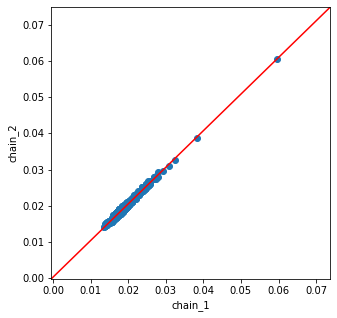

chain_1 chain_3 1.037847323488434 0.005726613699826349


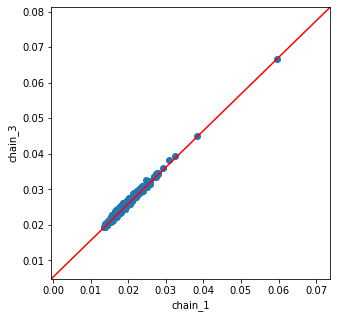

chain_1 chain_4 0.9994594282914853 0.00235680824845526


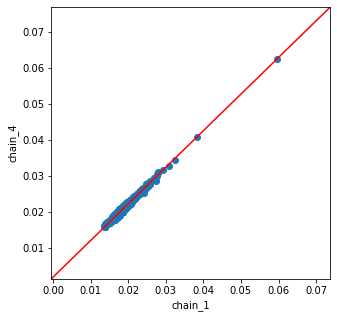

chain_1 chain_5 0.9970572386165526 0.004512077704577788


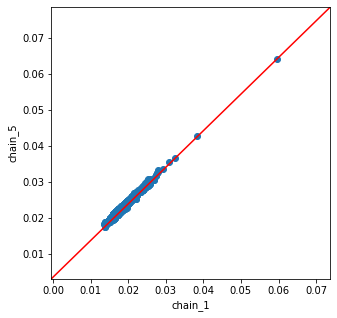

chain_2 chain_3 1.0310643234742154 0.005246937839661809


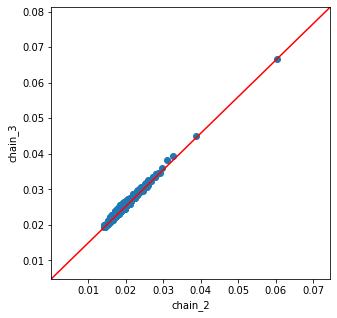

chain_2 chain_4 0.9915834889346269 0.0019202994290446885


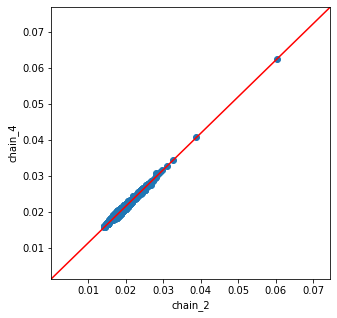

chain_2 chain_5 0.9904212351267282 0.004053517004555888


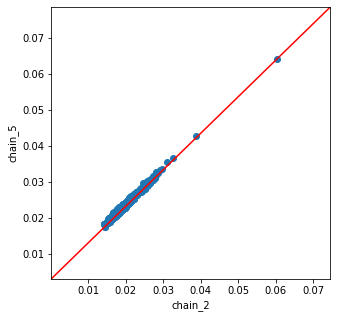

chain_3 chain_4 0.9495219050616924 -0.0028240512063210177


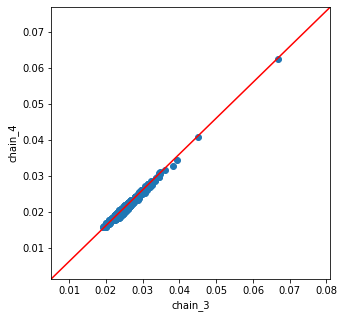

chain_3 chain_5 0.9489917467263382 -0.0006996993682608031


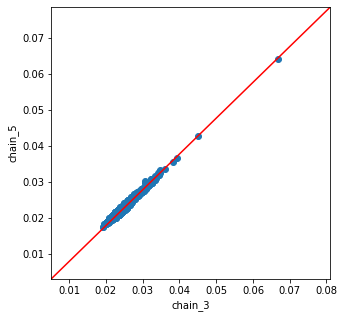

chain_4 chain_5 0.9876146159339303 0.002367366846889764


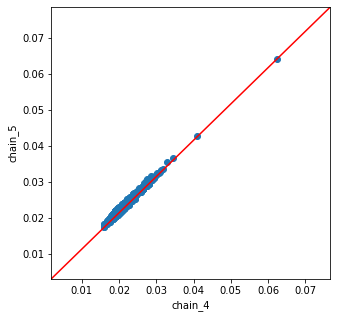

In [8]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [9]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.029971,0.021649,0.024202,0.028043,0.022289,0.022107,0.022964,0.026070,0.021060,0.024193,0.020837,0.021026,0.023473,0.024204,0.021887,0.023476,0.026903,0.021337,0.026643,0.022889,0.026567,0.022277,0.024033,0.023511,0.021579,0.020635,0.021605,0.021998,0.021074,0.022172,0.023149,0.023722,0.024771,0.022570,0.025637,0.025405,0.021395,0.022268,0.020960,0.022273
1,0.021649,0.030727,0.021796,0.029469,0.023793,0.021725,0.023716,0.020628,0.021595,0.020484,0.022142,0.022556,0.021826,0.025281,0.021150,0.025050,0.021431,0.022367,0.021302,0.022753,0.021707,0.023661,0.018876,0.021322,0.022511,0.019908,0.022929,0.021767,0.024490,0.023733,0.021551,0.025191,0.020045,0.022544,0.021823,0.021706,0.022155,0.021757,0.021571,0.021471
2,0.024202,0.021796,0.027879,0.028500,0.022437,0.023502,0.023093,0.023506,0.022090,0.022540,0.021617,0.022568,0.024079,0.024979,0.023717,0.023770,0.024645,0.022810,0.024094,0.023470,0.024730,0.023288,0.020782,0.023408,0.021558,0.021286,0.022284,0.022969,0.021472,0.022020,0.023345,0.023592,0.022545,0.023037,0.024001,0.023538,0.022442,0.023793,0.021456,0.023679
3,0.028043,0.029469,0.028500,0.064165,0.028005,0.028328,0.029668,0.026833,0.027222,0.026348,0.027739,0.029168,0.028734,0.031006,0.028315,0.030629,0.028121,0.029433,0.027597,0.029267,0.028254,0.029553,0.024708,0.027255,0.027770,0.025303,0.028009,0.027606,0.027900,0.027868,0.027357,0.031916,0.026385,0.028003,0.028050,0.027504,0.028464,0.028992,0.027747,0.028045
4,0.022289,0.023793,0.022437,0.028005,0.032567,0.021603,0.024818,0.021363,0.021651,0.020851,0.021708,0.021973,0.022316,0.024177,0.021046,0.025176,0.022157,0.022240,0.021715,0.022631,0.022418,0.022882,0.018937,0.021889,0.022816,0.021470,0.023038,0.021848,0.023237,0.023899,0.021797,0.025466,0.020387,0.022838,0.022083,0.021880,0.022037,0.022161,0.021284,0.021204


In [10]:
# sum across each matrix (to use in average calc below)
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[0.140324, 0.099793, 0.112124, ..., 0.104454, 0.09605 , 0.10261 ],
       [0.099793, 0.144162, 0.101292, ..., 0.101483, 0.098043, 0.099343],
       [0.112124, 0.101292, 0.130975, ..., 0.111386, 0.098129, 0.109874],
       ...,
       [0.104454, 0.101483, 0.111386, ..., 0.133063, 0.100648, 0.111874],
       [0.09605 , 0.098043, 0.098129, ..., 0.100648, 0.154191, 0.095114],
       [0.10261 , 0.099343, 0.109874, ..., 0.111874, 0.095114, 0.134422]])

In [11]:
# calculate average netural matrix
avg = summatrix / len(mats)
avg.shape

(40, 40)

In [12]:
# convert to dataframe
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(40, 40)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.028065,0.019959,0.022425,0.026496,0.020536,0.020268,0.021520,0.024348,0.019092,0.022323,0.019360,0.019156,0.021648,0.022709,0.020156,0.021992,0.024923,0.019523,0.024662,0.021001,0.024391,0.020444,0.022281,0.021989,0.020089,0.019281,0.019781,0.020169,0.019282,0.020354,0.021204,0.022015,0.023106,0.020844,0.023523,0.023601,0.019682,0.020891,0.019210,0.020522
1,0.019959,0.028832,0.020258,0.027897,0.022145,0.020024,0.022478,0.019053,0.019780,0.018661,0.020617,0.020682,0.020139,0.023483,0.019575,0.023620,0.019707,0.020783,0.019444,0.021046,0.019653,0.021830,0.017277,0.019986,0.021039,0.018651,0.021106,0.020019,0.022768,0.022029,0.019646,0.023516,0.018558,0.020876,0.019834,0.020117,0.020518,0.020297,0.019609,0.019869
2,0.022425,0.020258,0.026195,0.026921,0.020900,0.021711,0.021483,0.021832,0.020096,0.020624,0.020188,0.020711,0.022313,0.023321,0.021935,0.022325,0.022797,0.020982,0.022163,0.021768,0.022616,0.021412,0.019039,0.021952,0.020150,0.019911,0.020403,0.021123,0.019695,0.020396,0.021515,0.021837,0.020899,0.021384,0.021955,0.021847,0.020614,0.022277,0.019626,0.021975
3,0.026496,0.027897,0.026921,0.062719,0.026593,0.026788,0.028449,0.025401,0.025571,0.024665,0.026416,0.027554,0.027029,0.029756,0.026926,0.029392,0.026496,0.027913,0.026042,0.027988,0.026386,0.028142,0.023277,0.026007,0.026368,0.024288,0.026363,0.026093,0.026343,0.026503,0.025814,0.030339,0.024968,0.026622,0.026185,0.026164,0.027130,0.027767,0.026027,0.026753
4,0.020536,0.022145,0.020900,0.026593,0.030796,0.019869,0.023265,0.019699,0.019983,0.018886,0.020261,0.019941,0.020533,0.022749,0.019407,0.023577,0.020291,0.020531,0.019746,0.021005,0.020266,0.021141,0.017257,0.020341,0.021233,0.020141,0.021042,0.019958,0.021428,0.022087,0.019982,0.023539,0.018738,0.021166,0.020047,0.020034,0.020320,0.020571,0.019237,0.019620


In [13]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1600 1600
chain_1 (0.9964251387894194, 0.0)
chain_2 (0.9972433035241466, 0.0)
chain_3 (0.995350596926803, 0.0)
chain_4 (0.9957889553603647, 0.0)
chain_5 (0.9956785242640306, 0.0)


In [14]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [15]:
# save average matrix
omegafile = op.join(baydir, 'neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [17]:
# load poolsize file
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [18]:
# compare to columns on gfile
gfile = pd.read_table(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79


In [19]:
# compare computationally
list(poolsizefile.columns) == gfilecols

True

In [20]:
# put columns on matrix for archiving
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
JP_p98,0.028065,0.019959,0.022425,0.026496,0.020536,0.020268,0.021520,0.024348,0.019092,0.022323,0.019360,0.019156,0.021648,0.022709,0.020156,0.021992,0.024923,0.019523,0.024662,0.021001,0.024391,0.020444,0.022281,0.021989,0.020089,0.019281,0.019781,0.020169,0.019282,0.020354,0.021204,0.022015,0.023106,0.020844,0.023523,0.023601,0.019682,0.020891,0.019210,0.020522
JP_p31,0.019959,0.028832,0.020258,0.027897,0.022145,0.020024,0.022478,0.019053,0.019780,0.018661,0.020617,0.020682,0.020139,0.023483,0.019575,0.023620,0.019707,0.020783,0.019444,0.021046,0.019653,0.021830,0.017277,0.019986,0.021039,0.018651,0.021106,0.020019,0.022768,0.022029,0.019646,0.023516,0.018558,0.020876,0.019834,0.020117,0.020518,0.020297,0.019609,0.019869
JP_p93,0.022425,0.020258,0.026195,0.026921,0.020900,0.021711,0.021483,0.021832,0.020096,0.020624,0.020188,0.020711,0.022313,0.023321,0.021935,0.022325,0.022797,0.020982,0.022163,0.021768,0.022616,0.021412,0.019039,0.021952,0.020150,0.019911,0.020403,0.021123,0.019695,0.020396,0.021515,0.021837,0.020899,0.021384,0.021955,0.021847,0.020614,0.022277,0.019626,0.021975
JP_p24,0.026496,0.027897,0.026921,0.062719,0.026593,0.026788,0.028449,0.025401,0.025571,0.024665,0.026416,0.027554,0.027029,0.029756,0.026926,0.029392,0.026496,0.027913,0.026042,0.027988,0.026386,0.028142,0.023277,0.026007,0.026368,0.024288,0.026363,0.026093,0.026343,0.026503,0.025814,0.030339,0.024968,0.026622,0.026185,0.026164,0.027130,0.027767,0.026027,0.026753
JP_p14,0.020536,0.022145,0.020900,0.026593,0.030796,0.019869,0.023265,0.019699,0.019983,0.018886,0.020261,0.019941,0.020533,0.022749,0.019407,0.023577,0.020291,0.020531,0.019746,0.021005,0.020266,0.021141,0.017257,0.020341,0.021233,0.020141,0.021042,0.019958,0.021428,0.022087,0.019982,0.023539,0.018738,0.021166,0.020047,0.020034,0.020320,0.020571,0.019237,0.019620


In [21]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'neutral_average_omegafile_HEADERIDX.txt'), index=True, header=True, sep='\t')

# make efile

In [21]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [22]:
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [23]:
ncol(poolsizefile)  # num pops

40

In [24]:
# load center/standardized environmental data
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_std_env-19variables.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata.head()

,id1,id2,our_id,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,0.861856,1.380348,1.500889,-1.335983,1.470853,0.696905,1.922962,1.056481,-0.138853,1.486412,1.414019,-0.056960,1.214977,0.923098,-0.803992,0.339162,-1.165432,-0.735070,1.016494
JP_p97,8060006,37,JP_p97,56.1167,-116.9167,636,1.161285,1.394176,-1.225419,0.745700,-0.648921,-0.361685,-0.477565,-1.807367,-1.260140,-0.939544,-0.945179,-1.555599,-1.674698,-0.676726,-0.864621,1.013853,0.465168,0.749920,-2.316274
JP_p60,3260,17,JP_p60,46.7200,-84.3900,203,-0.236050,-0.085386,0.084487,-0.837726,0.909736,-0.655738,0.068586,0.497681,0.294712,0.622936,0.874203,-0.032592,-0.229861,0.475148,0.278680,-0.262870,-1.053748,0.155924,1.016494
JP_p100,9040116,40,JP_p100,55.7667,-97.8167,205,-0.874832,-0.154524,-1.882146,2.424876,-1.771154,-0.126443,-1.849295,-2.366167,-0.983556,-2.378670,-1.964832,-1.031685,-1.477675,-2.724500,-0.362262,0.328782,1.693702,2.531907,-1.871904


In [25]:
# check for 37 rows
envdata.shape

(40, 25)

In [26]:
# expecting 19 env variables
len(list(envdata.columns)[6:])

19

In [27]:
# triple check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

AHM 4.884981308350689e-16 0.9999999999999999
CMD -1.6653345369377348e-16 0.9999999999999999
DD5 -2.1094237467877973e-16 0.9999999999999998
DD_0 -6.661338147750939e-17 1.0
EMT -1.126876369994534e-15 1.0
EXT 8.715250743307478e-16 0.9999999999999998
Eref -3.108624468950438e-16 1.0
FFP -5.551115123125783e-18 1.0
MAP 9.992007221626409e-17 1.0
MAT -1.6653345369377348e-16 0.9999999999999999
MCMT -2.7755575615628914e-17 1.0
MSP -1.2212453270876723e-16 1.0000000000000002
MWMT 5.995204332975846e-16 1.0
NFFD 7.216449660063518e-16 1.0
PAS 6.661338147750939e-17 1.0000000000000002
SHM -1.4432899320127036e-16 1.0
TD 4.440892098500626e-16 0.9999999999999999
bFFP 1.6986412276764896e-15 1.0000000000000002
eFFP -2.55351295663786e-15 0.9999999999999998


In [28]:
# convert jp envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
JP_p98,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
JP_p31,-0.715136,-1.067151,-0.266951,0.123323,-0.357972,-0.302874,-0.401358,0.078581,0.309662,-0.158304,-0.225423,0.613163,-0.295535,-0.292768,0.477891,-0.823383,0.152450,0.155924,0.238848
JP_p93,1.201209,0.633654,0.560171,0.488593,-0.461882,1.285011,-0.261645,0.846931,-0.961130,-0.158304,-0.665274,-0.824556,0.886605,0.539141,-0.951235,1.200691,1.068267,-1.032068,0.572125
JP_p24,-1.313994,-1.606431,0.407526,-1.109019,0.826608,-0.420495,1.249798,0.148431,2.077558,0.910761,1.134115,2.233642,0.098512,-0.100789,1.439303,-1.633012,-1.232443,-0.141074,0.238848
JP_p14,-1.174261,-1.177773,-0.515443,-0.389119,0.265491,-0.596927,-0.083828,-0.619918,1.139415,0.047286,0.414359,0.929948,-0.361209,-1.060683,1.768435,-1.062120,-0.584671,0.898419,-0.316613


In [29]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
AHM,0.702161,-0.715136,1.201209,-1.313994,-1.174261,0.083341,-0.894794,0.762047,0.123265,0.522504,-1.413804,0.861856,0.901780,-1.054489,0.362808,-0.834908,0.861856,0.622313,1.201209,-0.735098,1.979725,0.103303,1.161285,1.281057,-1.513613,0.043417,-0.615327,0.542465,-0.894794,-1.713233,-1.114375,-1.313994,1.181247,-0.236050,0.282960,-0.874832,0.103303,2.179344,-0.715136,0.063379
CMD,0.550687,-1.067151,0.633654,-1.606431,-1.177773,-0.030075,-0.361940,0.882552,0.052891,0.232651,-1.454326,1.380348,0.536860,-1.053324,0.315617,-0.762942,0.412411,1.560108,0.550687,-0.071558,2.182354,0.536860,1.394176,1.020829,-1.634086,-0.624666,-0.597010,-0.016248,-1.246911,-1.606431,-0.583182,-1.634086,0.993173,-0.085386,0.343272,-0.154524,0.523032,1.961111,-0.541699,0.246478
DD5,-0.923679,-0.266951,0.560171,0.407526,-0.515443,1.074904,0.670217,-1.001776,0.808663,-0.515443,-0.866881,1.500889,0.379127,-0.302450,2.193116,0.698616,-0.810083,1.795529,-0.952078,-0.593540,0.755414,1.216899,-1.225419,0.048988,-1.378063,0.290380,1.273697,0.659568,-0.053958,-2.169687,-1.310616,-0.327299,-0.639688,0.084487,-0.881080,-1.882146,1.302096,-0.018459,0.187434,0.727015
DD_0,1.114516,0.123323,0.488593,-1.109019,-0.389119,-0.647999,-1.330663,1.462054,-1.477835,1.327294,0.327236,-1.335983,0.479727,-0.568207,-1.077102,-1.516844,1.148206,-1.422867,0.513417,0.235032,0.352060,-1.174626,0.745700,0.694278,0.933654,0.426532,-0.837726,0.431852,-0.493735,0.630445,0.891098,-1.653377,0.912376,-0.837726,1.343253,2.424876,-0.951208,0.511644,-0.307554,-0.385572
EMT,-1.002217,-0.357972,-0.461882,0.826608,0.265491,0.348620,1.263032,-1.480205,1.907277,-0.877524,-0.420318,1.470853,-0.503446,0.348620,0.826608,1.699456,-1.043781,1.637110,-0.856742,-0.524228,-0.337190,1.117557,-0.648921,-0.752832,-0.835960,-0.482664,0.639569,-0.295625,0.494094,-0.628139,-0.939870,2.406047,-0.919088,0.909736,-1.126909,-1.771154,0.847390,-0.794396,0.036888,0.016106


In [30]:
# save
efile.to_csv(op.join(baydir, 'efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

# create gfiles for GEA from "SNP" files (ADP < 1000)

In [ ]:
# RESTART NOTEBOOK!!!

In [2]:
lview,dview = get_client()

36 36


In [4]:
linenums

{'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt': 1235752}

In [5]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

# get job returns
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
snps.head()


Watching 124 jobs ...


100%|██████████| 124/124 [00:26<00:00,  4.60it/s]


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
Scaffold_1-15421,Scaffold_1,15421,A,G,0.674211,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26,26.0,76.92%,1.827300e-09,20.0,6.0,G/G,113.0,28,28.0,85.71%,4.701500e-12,24.0,4.0,A/G,30.0,14,14.0,57.14%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,>super4,15421,>super4-15421,0.325789
Scaffold_1-47333,Scaffold_1,47333,G,A,0.105707,-10.0,SNP,PASS,109,7,33,0,0,G/A,15.0,61,61.0,8.2%,2.870000e-02,5.0,56.0,G/A,34.0,121,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85,85.0,21.18%,1.395700e-06,18.0,67.0,G/G,268.0,144,144.0,0%,1.000000e+00,0.0,144.0,G/A,34.0,133,133.0,8.27%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77,77.0,9.09%,6.775500e-03,7.0,70.0,G/A,18.0,109,109.0,5.5%,1.456000e-02,6.0,103.0,G/A,44.0,103,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,>super4,47333,>super4-47333,0.105707
Scaffold_1-47418,Scaffold_1,47418,T,A,0.217593,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,33.0,155,155.0,7.1%,4.063500e-04,11.0,144.0,T/A,94.0,137,137.0,21.17%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,>super4,47418,>super4-47418,0.217593
Scaffold_1-47461,Scaffold_1,47461,T,G,0.090661,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133,133.0,0%,1.000000e+00,0.0,133.0,T/G,15.0,103,103.0,4.85%,2.973700e-02,5.0,98.0,T/G,235.0,161,161.0,40.99%,2.881900e-24,66.0,95.0,T/G,27.0,120,120.0,7.5%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,>super4,47461,>super4-47461,0.090661
Scaffold_1-47513,Scaffold_1,47513,C,G,0.520739,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,62.0,168,168.0,11.9%,5.230200e-07,20.0,148.0,C/G,179.0,96,96.0,50%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139,139.0,69.78%,1.159100e-41,97.0,42.0,C/G,219.0,

In [6]:
snps.shape

(1235752, 338)

In [7]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((1235028, 338), (1235752, 338))

In [8]:
# how many snps were dropped?
nrow(snps) - nrow(reduced)

724

In [11]:
# test function
x = get_counts(reduced.index[:5], 40)
x.head()

100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_1-15421,16,6,27,5,20,6,24,4,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
Scaffold_1-47333,56,5,110,11,67,18,144,0,122,11,102,16,87,5,81,4,131,5,93,8,135,9,125,7,95,9,169,16,102,23,62,5,100,23,149,5,92,23,119,3,78,12,122,5,87,7,80,14,74,2,110,7,142,5,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,103,6,89,14,134,0,96,9
Scaffold_1-47418,56,14,114,26,72,25,144,11,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
Scaffold_1-47461,77,0,133,0,98,5,95,66,111,9,96,19,91,6,103,6,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,80,6,95,3,67,12,127,14,120,16,78,5,119,15,124,8,104,12,54,5,67,0,93,6,46,0,74,10,100,2,89,2,99,24,101,24
Scaffold_1-47513,43,34,75,58,38,59,20,148,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [12]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

123

In [14]:
# restart engines
lview,dview = get_client()

25 25


In [15]:
reduced[important_cols].shape

(1235028, 123)

In [16]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [17]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

49402

In [20]:
# send jobs to engines for get_counts() to get a gfile for all SNPs
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 40)))
        tosend = []
watch_async(jobs)


Watching 25 jobs ...


100%|██████████| 25/25 [01:54<00:00,  4.60s/it]


In [21]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [22]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [23]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [24]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [25]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [26]:
# write a file for use in baypass (no header/index) and one for us to use later to label loci (header/index = True)
jobs = []
files = [op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [28]:
watch_async(jobs)


Watching 2 jobs ...


100%|██████████| 2/2 [00:00<00:00, 10394.81it/s]


In [29]:
# load gfile with header/index
gfile = pd.read_table(op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'), index_col=0)
gfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_1-15421,16,6,27,5,20,6,24,4,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
Scaffold_1-47333,56,5,110,11,67,18,144,0,122,11,102,16,87,5,81,4,131,5,93,8,135,9,125,7,95,9,169,16,102,23,62,5,100,23,149,5,92,23,119,3,78,12,122,5,87,7,80,14,74,2,110,7,142,5,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,103,6,89,14,134,0,96,9
Scaffold_1-47418,56,14,114,26,72,25,144,11,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
Scaffold_1-47461,77,0,133,0,98,5,95,66,111,9,96,19,91,6,103,6,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,80,6,95,3,67,12,127,14,120,16,78,5,119,15,124,8,104,12,54,5,67,0,93,6,46,0,74,10,100,2,89,2,99,24,101,24
Scaffold_1-47513,43,34,75,58,38,59,20,148,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [30]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [31]:
gfile.shape

(1235028, 80)

In [32]:
reduced.shape

(1235028, 338)

In [33]:
# create a directory to break up main gfile into tiny gfiles for parallel baypass calls
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [34]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [35]:
# how many files if I split up main gfile into gfiles with 1500 SNPs each?
nrow(gfile)/1500

823.352

In [37]:
# restart engines
lview,dview = get_client()

56 56


In [38]:
# write small gfiles to file
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)


Watching 824 jobs ...


100%|██████████| 824/824 [00:00<00:00, 204527.55it/s]


In [40]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [41]:
# make sure there are as many baypass gfiles as there are pkl files (pkl files contain row names aka loci names)
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
len(files) == len(pkls)

True

In [42]:
len(files) , len(pkls)

(824, 824)

In [43]:
smallgfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_22229-1027082,8,6,148,79,41,22,282,124,615,326,466,212,89,49,12,2,21,6,8,2,1422,755,358,177,24,5,1401,679,120,56,210,87,24,1,212,80,30,8,98,22,12,3,167,63,18,5,59,26,61,30,101,51,68,40,142,60,201,108,265,106,279,111,203,87,16,9,683,365,13,9,15,5,213,83,20,11,244,113,185,89
Scaffold_22229-1027084,10,4,134,87,44,18,257,136,546,372,411,250,87,48,11,4,18,6,6,4,1273,875,336,185,20,8,1235,819,100,70,193,106,10,12,175,111,27,10,64,45,12,2,135,92,17,6,48,34,43,50,94,54,73,38,136,63,185,115,213,139,253,133,158,128,11,14,657,376,17,6,9,12,160,123,18,11,225,122,167,106
Scaffold_22229-1027085,14,0,200,27,56,5,357,36,832,91,602,59,126,11,13,2,24,1,10,1,1953,208,479,43,21,6,1861,188,153,18,268,33,21,1,260,26,31,5,102,9,14,0,202,25,23,0,76,6,82,11,136,15,105,5,189,10,274,30,327,34,347,41,246,43,21,4,925,109,19,4,18,2,257,28,27,3,322,21,244,30
Scaffold_22229-1027092,9,4,188,30,48,10,340,42,777,115,536,108,121,14,8,5,19,5,7,4,1798,251,430,75,26,2,1740,245,161,11,261,33,13,6,241,38,33,4,92,16,12,2,197,29,20,2,66,13,87,5,122,21,96,12,163,28,257,36,300,57,314,58,224,64,22,4,872,139,21,2,13,6,248,30,27,3,291,38,221,35
Scaffold_22229-1027093,9,4,128,89,34,24,238,137,523,361,358,279,83,49,4,9,11,13,6,5,1224,815,309,197,18,11,1179,778,118,53,158,135,11,9,172,100,24,11,55,50,11,3,132,91,9,13,41,36,57,34,95,55,65,40,102,87,183,113,196,154,229,145,172,111,12,14,605,401,15,7,10,10,181,92,24,6,204,132,161,94


In [46]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'), sep='\t')
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [47]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in tnb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

0.225

# create commands to run baypass using gfiles from above

In [48]:
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [49]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

824

In [50]:
# get efile
efile = op.join(baydir, 'efile_std_noheaderidx.txt')
op.exists(efile)

True

In [51]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'poolsizefile_noheaderidx.txt')
op.exists(omegafile), op.exists(poolsizefile)

(True, True)

In [52]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [53]:
# set compute canada dirs
cbay = '/scratch/lindb/jp_gea'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')

In [55]:
# create baypass commands for each gfile for 5 chains each
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 824/824 [00:00<00:00, 32018.48it/s]


4120

In [56]:
cmds[0]

'i_baypass -gfile /scratch/lindb/jp_gea/individual_gfiles/all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt -efile /scratch/lindb/jp_gea/efile_std_noheaderidx.txt -omegafile /scratch/lindb/jp_gea/neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/jp_gea/poolsizefile_noheaderidx.txt -outprefix all_snps_ADP-lt-1000_gfile_0000_chain_1 -d0yij 8 -seed 71834 -pilotlength 1000 -nval 50000 -npilot 40 '

In [57]:
# create catfiles for baypass commands - for requests of a single node with 48 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 4120/4120 [00:00<00:00, 338853.90it/s]


86

In [58]:
# create slurm jobs, cat catfiles at GNU parallel
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=3-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"


cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 86/86 [00:00<00:00, 6016.55it/s]


86

# transfer to cedar, graham, beluga, and arc

In [2]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [3]:
# get infiles
files = fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile'])
files

['/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/poolsizefile_noheaderidx.txt']

In [5]:
# get gfiles
gfile_dir = op.join(baydir, 'individual_gfiles')
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

827

In [10]:
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
shdir = op.join(cmddir, 'shfiles')

In [11]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

999

In [12]:
def exe(src, dst):
    import subprocess
    import shutil
    out = subprocess.check_output([shutil.which('rsync'), '-azv', src, dst])
    return out

In [13]:
lview,dview = get_client()

56 56


In [14]:
files[0]

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/efile_std_noheaderidx.txt'

In [16]:
cbay = '/scratch/lindb/jp_gea'

In [17]:
arcbay = '/home/brandon.lind/JP_GEA'

In [18]:
syncs = []
dirs = []
arcdirs = []
for src in files:
    dst = 'cedar:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'beluga:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'graham:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    dirs.append(op.dirname(dst))
    
    dst = 'arc:' + src.replace(baydir, arcbay)
    syncs.append((src, dst))
    arcdirs.append(op.dirname(dst))
arcdirs = uni(arcdirs)
dirs = uni(dirs)
dst

'arc:/home/brandon.lind/JP_GEA/cmd_files/run_01/catfile_0085.txt'

In [41]:
for d in dirs:
# for d in arcdirs:
    print('mkdir -p', d.split(":")[1])

mkdir -p /scratch/lindb/jp_gea/cmd_files/shfiles
mkdir -p /scratch/lindb/jp_gea/individual_gfiles
mkdir -p /scratch/lindb/jp_gea/cmd_files/run_01
mkdir -p /scratch/lindb/jp_gea


In [21]:
len(syncs)

3996

In [45]:
def make_jobs(cmd, inputs:list, lview) -> list:
    """Send each arg from inputs to a function command; async."""
    print(f"making jobs for {cmd.__name__}")
    jobs = []
    for arg in nb(inputs, desc=f'{cmd.__name__} jobs'):
        jobs.append(lview.apply_async(cmd, *arg))
    return jobs

In [42]:
# execute system commands in parallel
jobs = make_jobs(exe, syncs, lview)
watch_async(jobs)

making jobs for exe




Watching 3996 jobs ...


100%|██████████| 3996/3996 [02:14<00:00, 29.77it/s]


In [43]:
# see if any failed
needed = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            if not b'speedup' in j.r:
                needed.append(syncs[i])
        except:
            needed.append(syncs[i])
len(needed)

0

In [46]:
# execute system commands in parallel
jobs = make_jobs(exe, needed, lview)
watch_async(jobs)

exe jobs: 0it [00:00, ?it/s]


making jobs for exe

Watching 0 jobs ...


0it [00:00, ?it/s]
